In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr
from talib import RSI, BBANDS, MACD, ATR

In [3]:
MONTH = 21 # trading day in a month
YEAR = 12 * MONTH
START = '2013-01-01'
END = '2017-12-31'
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [4]:
ohlcv = ['adj_open', 'adj_close', 'adj_low', 'adj_high', 'adj_volume']

In [5]:
DATA_STORE = '../data/assets.h5'

In [6]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[START:END, :], ohlcv]
              .rename(columns=lambda x: x.replace('adj_', ''))
              .assign(volume=lambda x: x.volume.div(1000))
              .swaplevel()
              .sort_index())

    stocks = (store['us_equities/stocks']
              .loc[:, ['marketcap', 'ipoyear', 'sector']])

In [7]:
# want at least 2 years of data
min_obs = 2 * YEAR

In [8]:
# number of daily price per ticker
nobs = prices.groupby(level='ticker').size()

In [9]:
# keep those tickers that have at least 2 years of data
keep = nobs[nobs > min_obs].index

In [10]:
prices = prices.loc[idx[keep, :], :]

In [11]:
stocks = stocks[~stocks.index.duplicated() & stocks.sector.notnull()]

In [12]:
stocks.sector = stocks.sector.str.lower().str.replace(' ', '_')

In [13]:
shared = prices.index.get_level_values('ticker').unique().intersection(stocks.index)

In [14]:
stocks = stocks.loc[shared,:]
prices = prices.loc[idx[shared, :], :]

In [15]:
stocks.sector.value_counts()

consumer_services        440
finance                  393
technology               297
health_care              297
capital_goods            227
basic_industries         138
consumer_non-durables    126
energy                   123
public_utilities         105
consumer_durables         78
miscellaneous             69
transportation            55
Name: sector, dtype: int64

In [16]:
# use 21-day rolling average of the adjusted dollar volume traded to select the most liquid stocks for the model
# excluding stocks with low dollar volumes can also reduce the noise of price data
prices['dollar_vol'] = prices.close * prices.volume

In [17]:
prices['dollar_vol_1m'] = prices.dollar_vol.groupby('ticker').rolling(window=21).mean().values

In [18]:
prices['dollar_vol_rank'] = prices.groupby('date').dollar_vol_1m.rank(ascending=False)

In [33]:
prices

open      close        low       high    volume  \
ticker date                                                               
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287.700   
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114.300   
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601.500   
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567.600   
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787.500   
...                      ...        ...        ...        ...       ...   
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209.585   
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213.951   
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227.325   
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162.070   
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222.040   

                      dollar_vol  dollar_vol_1m  dollar_vol_rank        rsi  \
ticker date                                                                   
A      2013-01-02  181430.981611            NaN              NaN        NaN   
       2013-01-03  119142.939438            NaN              NaN        NaN   
       2013-01-04  135882.822089            NaN              NaN        NaN   
       2013-01-07   75273.116328            NaN              NaN        NaN   
       2013-01-08   81066.830411            NaN              NaN        NaN   
...                          ...            ...              ...        ...   
ZUMZ   2017-12-22    4495.598250   11930.001226           1288.0  61.077094   
       2017-12-26    4674.829350   11963.373076           1291.0  63.799097   
       2017-12-27    4807.923750   11786.938512           1293.0  56.369727   
       2017-12-28    3435.884000   11290.208650           1300.0  56.757082   
       2017-12-29    4623.983000   10790.612631           1312.0  52.959469   

                    bb_high    bb_low       atr  
ticker date                                      
A      2013-01-02       NaN       NaN       NaN  
       2013-01-03       NaN       NaN       NaN  
       2013-01-04       NaN       NaN       NaN  
       2013-01-07       NaN       NaN       NaN  
       2013-01-08       NaN       NaN       NaN  
...                     ...       ...       ...  
ZUMZ   2017-12-22  0.028426  0.086877 -0.419131  
       2017-12-26  0.010058  0.090436 -0.450751  
       2017-12-27  0.040577  0.057586 -0.282948  
       2017-12-28  0.039229  0.059005 -0.449763  
       2017-12-29  0.050887  0.042288 -0.515043  

[2904233 rows x 12 columns]

In [20]:
prices['rsi'] = prices.groupby(level='ticker').close.apply(RSI)

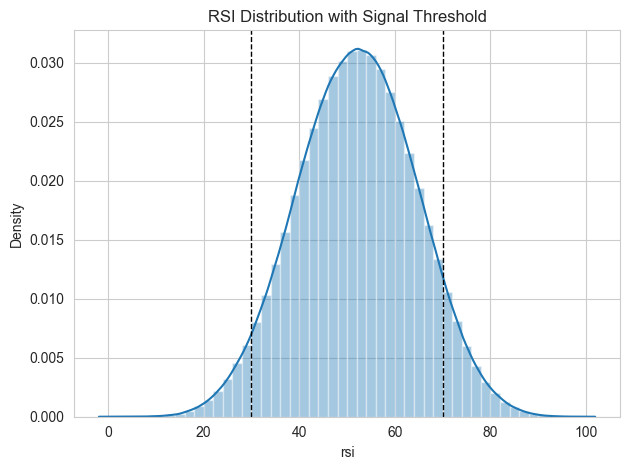

In [21]:
ax = sns.distplot(prices.rsi.dropna())
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
plt.tight_layout();

In [22]:
def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod=20)
    return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)

In [23]:
prices = (prices.join(prices
                      .groupby(level='ticker')
                      .close
                      .apply(compute_bb)))

In [24]:
prices['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p)
prices['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p)

In [25]:
prices

open      close        low       high    volume  \
ticker date                                                               
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287.700   
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114.300   
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601.500   
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567.600   
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787.500   
...                      ...        ...        ...        ...       ...   
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209.585   
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213.951   
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227.325   
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162.070   
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222.040   

                      dollar_vol  dollar_vol_1m  dollar_vol_rank        rsi  \
ticker date                                                                   
A      2013-01-02  181430.981611            NaN              NaN        NaN   
       2013-01-03  119142.939438            NaN              NaN        NaN   
       2013-01-04  135882.822089            NaN              NaN        NaN   
       2013-01-07   75273.116328            NaN              NaN        NaN   
       2013-01-08   81066.830411            NaN              NaN        NaN   
...                          ...            ...              ...        ...   
ZUMZ   2017-12-22    4495.598250   11930.001226           1288.0  61.077094   
       2017-12-26    4674.829350   11963.373076           1291.0  63.799097   
       2017-12-27    4807.923750   11786.938512           1293.0  56.369727   
       2017-12-28    3435.884000   11290.208650           1300.0  56.757082   
       2017-12-29    4623.983000   10790.612631           1312.0  52.959469   

                    bb_high    bb_low  
ticker date                            
A      2013-01-02       NaN       NaN  
       2013-01-03       NaN       NaN  
       2013-01-04       NaN       NaN  
       2013-01-07       NaN       NaN  
       2013-01-08       NaN       NaN  
...                     ...       ...  
ZUMZ   2017-12-22  0.028426  0.086877  
       2017-12-26  0.010058  0.090436  
       2017-12-27  0.040577  0.057586  
       2017-12-28  0.039229  0.059005  
       2017-12-29  0.050887  0.042288  

[2904233 rows x 11 columns]

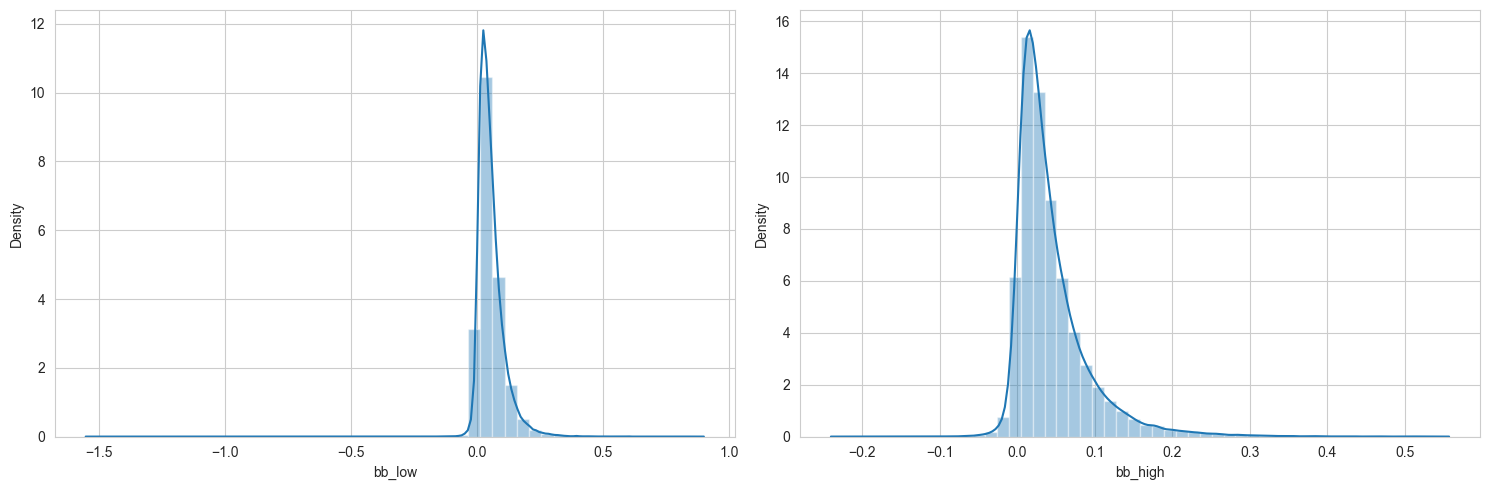

In [26]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_low'].dropna(), ax=axes[0])
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_high'].dropna(), ax=axes[1])
plt.tight_layout();

In [27]:
def compute_atr(stock_data):
    df = ATR(stock_data.high, stock_data.low, stock_data.close, timeperiod=14)
    return (df-df.mean())/df.std()

In [28]:
prices['atr'] = prices.groupby('ticker', group_keys=False).apply(compute_atr)

In [29]:
prices

open      close        low       high    volume  \
ticker date                                                               
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287.700   
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114.300   
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601.500   
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567.600   
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787.500   
...                      ...        ...        ...        ...       ...   
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209.585   
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213.951   
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227.325   
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162.070   
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222.040   

                      dollar_vol  dollar_vol_1m  dollar_vol_rank        rsi  \
ticker date                                                                   
A      2013-01-02  181430.981611            NaN              NaN        NaN   
       2013-01-03  119142.939438            NaN              NaN        NaN   
       2013-01-04  135882.822089            NaN              NaN        NaN   
       2013-01-07   75273.116328            NaN              NaN        NaN   
       2013-01-08   81066.830411            NaN              NaN        NaN   
...                          ...            ...              ...        ...   
ZUMZ   2017-12-22    4495.598250   11930.001226           1288.0  61.077094   
       2017-12-26    4674.829350   11963.373076           1291.0  63.799097   
       2017-12-27    4807.923750   11786.938512           1293.0  56.369727   
       2017-12-28    3435.884000   11290.208650           1300.0  56.757082   
       2017-12-29    4623.983000   10790.612631           1312.0  52.959469   

                    bb_high    bb_low       atr  
ticker date                                      
A      2013-01-02       NaN       NaN       NaN  
       2013-01-03       NaN       NaN       NaN  
       2013-01-04       NaN       NaN       NaN  
       2013-01-07       NaN       NaN       NaN  
       2013-01-08       NaN       NaN       NaN  
...                     ...       ...       ...  
ZUMZ   2017-12-22  0.028426  0.086877 -0.419131  
       2017-12-26  0.010058  0.090436 -0.450751  
       2017-12-27  0.040577  0.057586 -0.282948  
       2017-12-28  0.039229  0.059005 -0.449763  
       2017-12-29  0.050887  0.042288 -0.515043  

[2904233 rows x 12 columns]

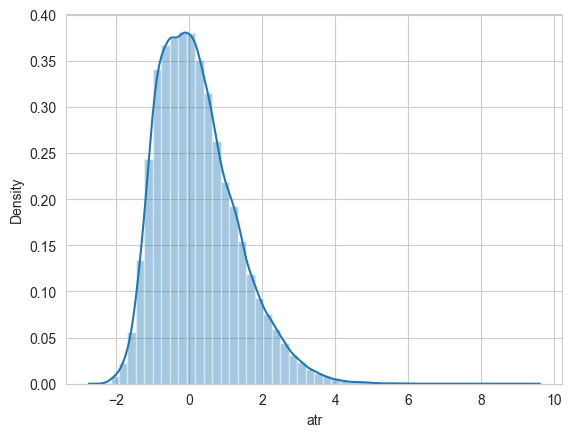

In [30]:
sns.distplot(prices[prices.dollar_vol_rank<50].atr.dropna());

In [31]:
def compute_macd(close):
    macd = MACD(close)[0]
    return (macd-np.mean(macd))/np.std(macd)

In [32]:
prices.close.apply(compute_macd)

TypeError: Argument 'real' has incorrect type (expected numpy.ndarray, got float)

In [ ]:
prices.groupby('date').close.apply(compute_macd)

In [ ]:
prices['macd'] = prices.groupby('ticker', group_keys=False).close.apply(compute_macd)

In [ ]:
prices

In [ ]:
sns.distplot(prices[prices.dollar_vol_rank<100].macd.dropna());

## compute lagged return

In [ ]:
lags = [1, 5, 10, 21, 42, 63]

In [ ]:
returns = prices.groupby('ticker').close.pct_change()
percentiles=[0.0001, 0.001, 0.01]
percentiles += [1-p for p in percentiles]

In [ ]:
returns.describe(percentiles=percentiles).iloc[2:].to_frame('percentiles').style.format(lambda x: f'{x:,.2%}')

In [ ]:
q= 0.0001
for lag in lags:
    prices[f'return_{lag}d'] = (prices.groupby(level='ticker').close
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(q),
                                                       upper=x.quantile(1 - q)))
                                .add(1)
                                .pow(1 / lag)
                                .sub(1)
                                )

In [ ]:
for t in [1, 2, 3, 4, 5]:
    for lag in [1, 5, 10, 21]:
        prices[f'return_{lag}d_lag{t}'] = (prices.groupby(level='ticker')
                                           [f'return_{lag}d'].shift(t * lag))

In [ ]:
for t in [1, 5, 10, 21]:
    prices[f'target_{t}d'] = prices.groupby(level='ticker')[f'return_{t}d'].shift(-t)

In [ ]:
prices = prices.join(stocks[['sector']])

In [35]:
prices['year'] = prices.index.get_level_values('date').year
prices['month'] = prices.index.get_level_values('date').month

In [36]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 14 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   open             2904233 non-null  float64
 1   close            2904233 non-null  float64
 2   low              2904233 non-null  float64
 3   high             2904233 non-null  float64
 4   volume           2904233 non-null  float64
 5   dollar_vol       2904233 non-null  float64
 6   dollar_vol_1m    2857273 non-null  float64
 7   dollar_vol_rank  2857273 non-null  float64
 8   rsi              2871361 non-null  float64
 9   bb_high          2859618 non-null  float64
 10  bb_low           2859585 non-null  float64
 11  atr              2871361 non-null  float64
 12  year             2904233 non-null  int64  
 13  month            2904233 non-null  int64  
dtypes: float64(12), int64(2)
memory usage: 38

In [ ]:
prices.assign(sector=pd.factorize(prices.sector, sort=True)[0]).to_hdf('data.h5', 'model_data/no_dummies')

In [ ]:
prices = pd.get_dummies(prices,
                        columns=['year', 'month', 'sector'],
                        prefix=['year', 'month', ''],
                        prefix_sep=['_', '_', ''],
                        drop_first=True)

In [ ]:
prices.to_hdf('data.h5', 'model_data')

## explore data

In [ ]:
target = 'target_5d'
top100 = prices[prices.dollar_vol_rank<100].copy()

In [ ]:
top100.loc[:, '']

In [ ]:
top100.loc[:, 'rsi_signal'] = pd.cut(top100.rsi, bins=[0, 30, 70, 100])

In [ ]:
top100.groupby('rsi_signal')['target_5d'].describe()

## Bollinger Bands

In [ ]:
metric = 'bb_low'
j = sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

In [ ]:
metric = 'bb_high'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')